In [79]:
#  short workbook to convert currency string into float number value
import pandas as pd
import numpy as np

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
from statsmodels.tsa.seasonal import seasonal_decompose

In [80]:
df = pd.read_csv('ma_lga_12345.csv', index_col = 0, parse_dates = True)

In [81]:
df

,MA,type,bedrooms
saledate,,,
2007-09-30,441854,house,2
2007-12-31,441854,house,2
2008-03-31,441854,house,2
2008-06-30,441854,house,2
2008-09-30,451583,house,2
...,...,...,...
2018-09-30,603281,unit,3
2018-12-31,601167,unit,3
2019-03-31,605637,unit,3


In [82]:
# 1st : visualise different scenarios

In [83]:
list_type = set(df.type)
print(f"Possible housing types {list_type}")

list_bed = set(df.bedrooms)
len(list_bed)
print(f"Possible nb of bedrooms {list_bed}")

combined = [(f,s) for f in list_type for s in list_bed]


Possible housing types {'house', 'unit'}
Possible nb of bedrooms {1, 2, 3, 4, 5}


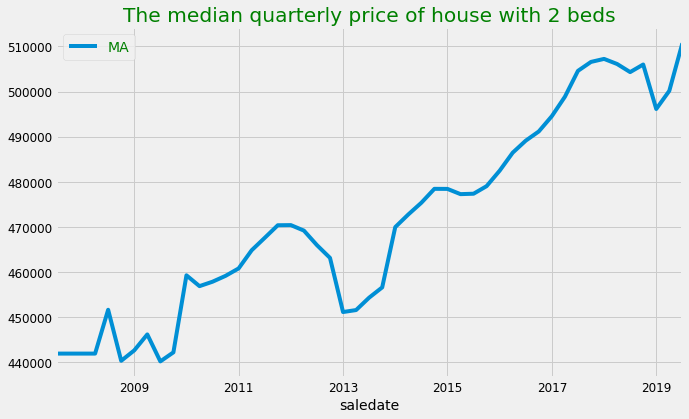

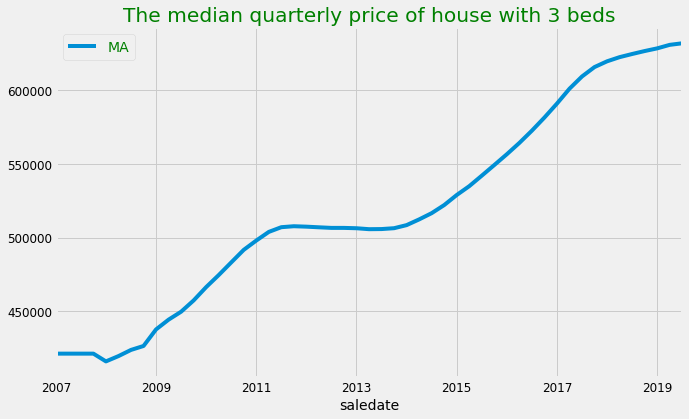

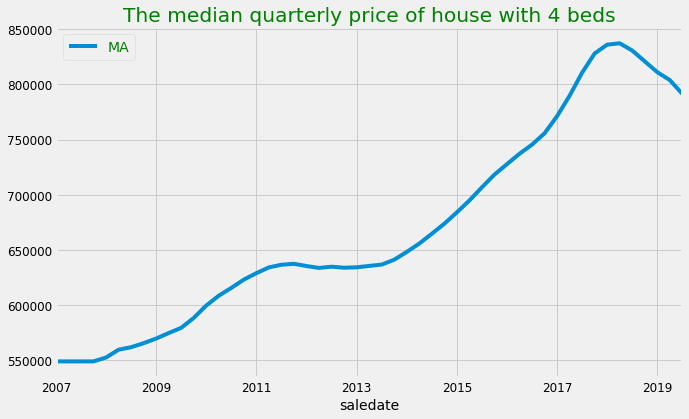

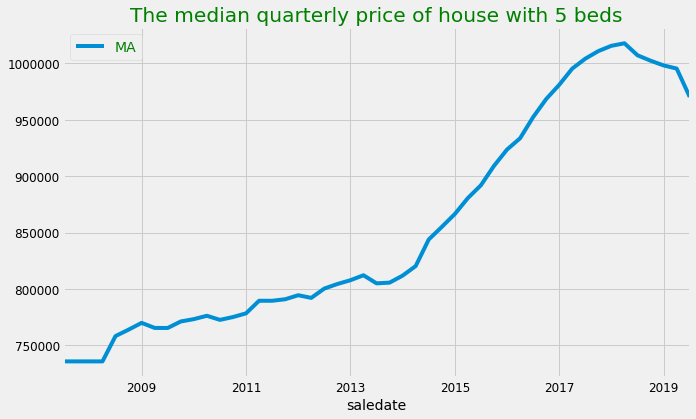

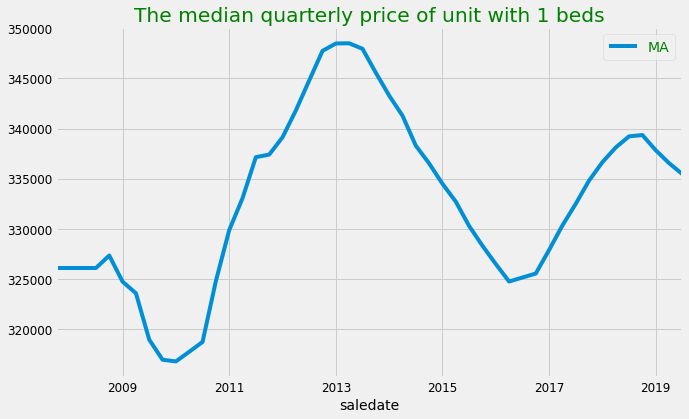

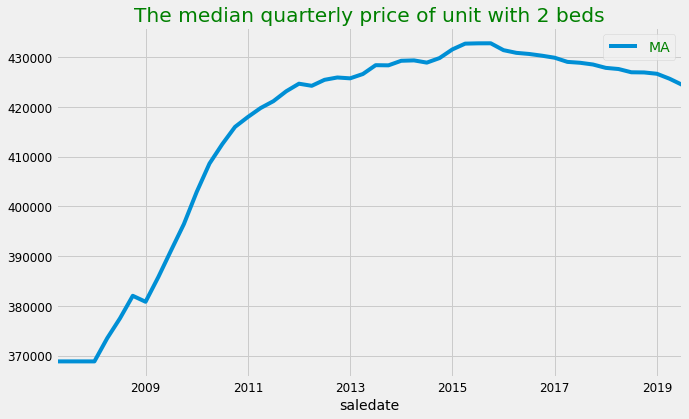

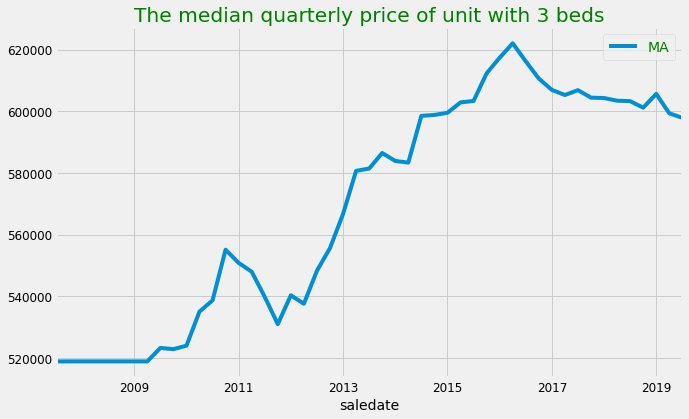

In [84]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        current_df.plot(figsize= (10,6), title = ('The median quarterly price of ' + i + ' with ' + str(j) + ' beds' ))
#     plot.show()

The line graphs show that the prices of big houses and units went down over the past few years and went up for the 2 and 3 bed house

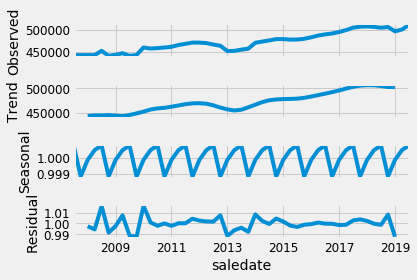

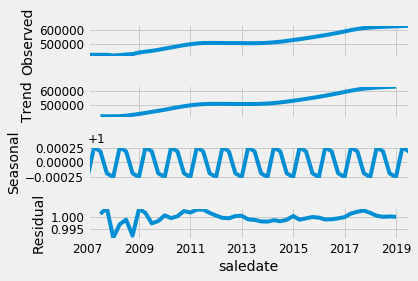

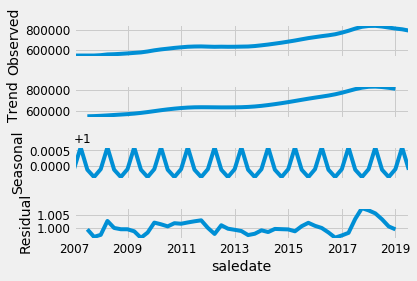

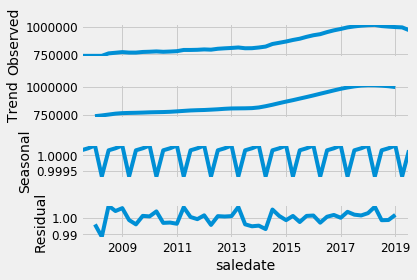

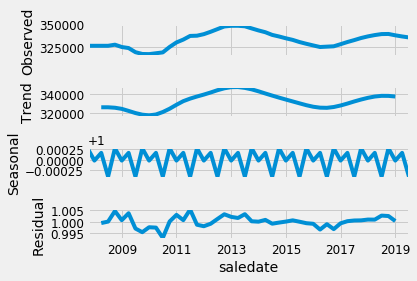

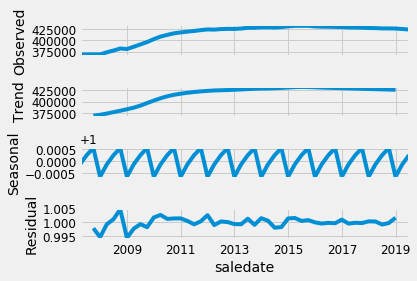

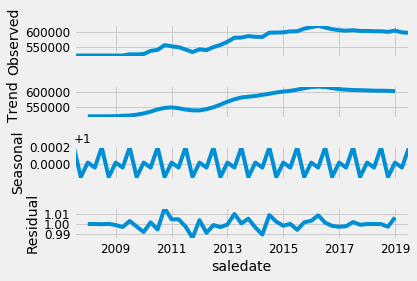

In [85]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        decomposition = seasonal_decompose(current_df['MA'], model='multiplicative')
        fig = decomposition.plot()
        plt.show()


The decomposition shows the strong seasonality for all types of housing and changing trends

In [86]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [87]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        print(adf_test(current_df['MA']))

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.416207
p-value                  0.907357
# lags used              1.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic       1.001044
p-value                  0.994277
# lags used             10.000000
# observations          40.000000
critical value (1%)     -3.605565
critical value (5%)     -2.937069
critical value (10%)    -2.606986
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic      -1.694178
p-value                  0.434115
# lags used              2.000000
# observations          48.000000
critical value (1%)     -3.574589
critical va

In [88]:
# autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

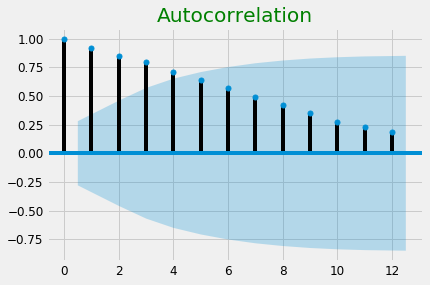

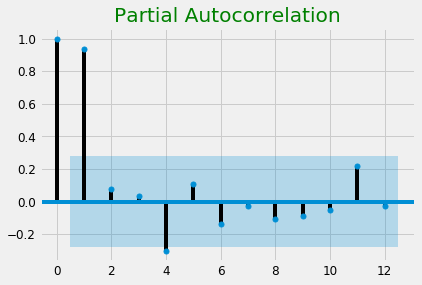

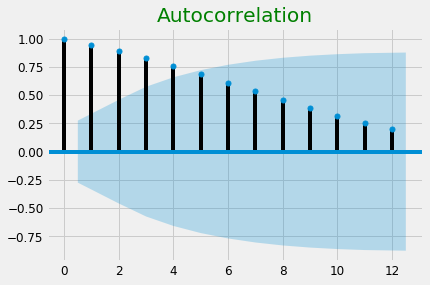

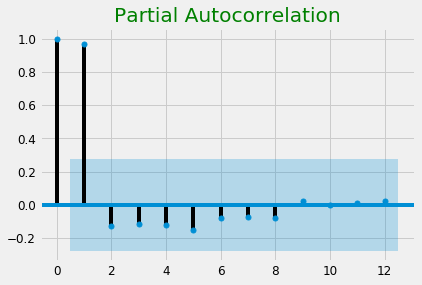

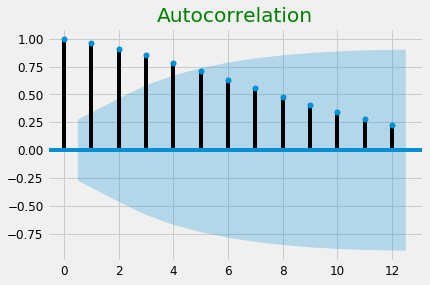

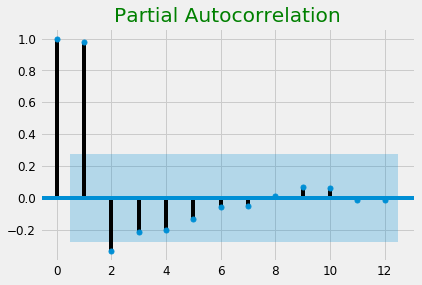

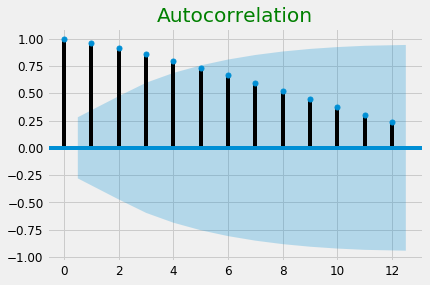

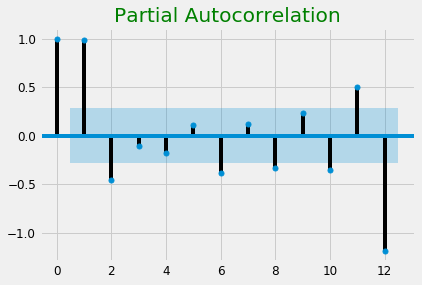

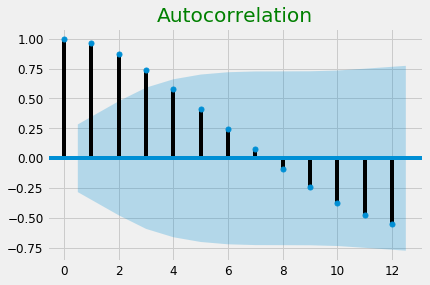

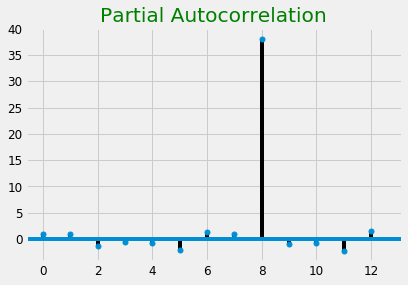

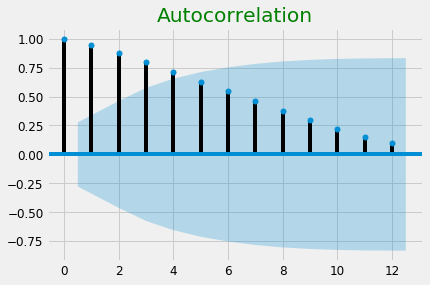

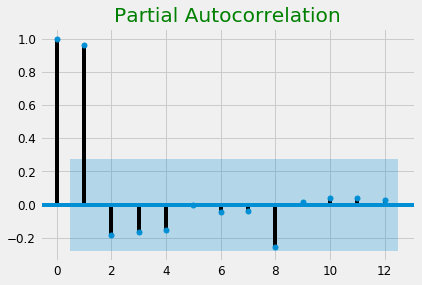

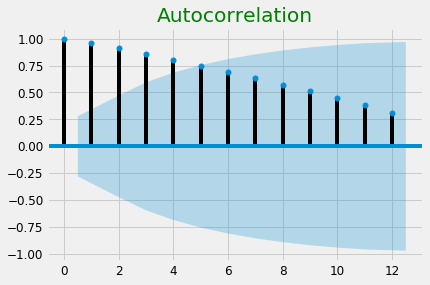

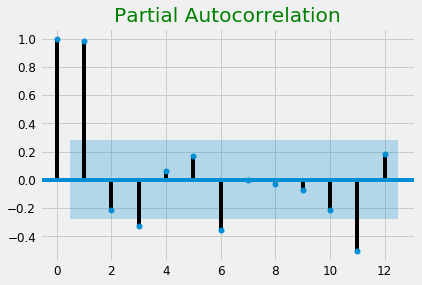

In [89]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        plot_acf(current_df, lags = 12); 
        plot_pacf(current_df, lags = 12); 
        
# how to read those charts:
# if autocorrelation plots shows the positive autocorrelation with n-lag it suggests to use AR model with n-lags
# if autocorrelation plots shows the negative autocorrelation then it suggests using MA model

In [90]:
from pmdarima import auto_arima

By the look on the decompostion charts, although there is some seasonality, its scale is much lower than the changes in trend and therefore the seasonality will not be taken into account for creating the time series model

In [91]:

for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        stepwise_fit = auto_arima(current_df['MA'], start_p = 0, start_q= 0, max_p = 6, max_q = 3,seasonal = False).summary()
        print(stepwise_fit)
#         stepwise_fit.plot()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   48
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -477.721
Method:                           css   S.D. of innovations           5082.632
Date:                Fri, 22 May 2020   AIC                            959.442
Time:                        23:03:02   BIC                            963.185
Sample:                             1   HQIC                           960.856
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1434.5417    733.615      1.955      0.056      -3.317    2872.400
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observat

## Checking the auto_arima results on the example of House with 2 beds

1. adf test says it is not non-stationary
2. auto-arima suggest differencing by one - try if that will make data stationary
3. 

In [92]:
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.tools import diff

In [94]:
# resenting index for calc differencing
df_h2 = df.reset_index()
df_h2 = df_h2[(df_h2.type == 'house') & (df_h2.bedrooms == 2)]

# differencing
df_h2['Diff'] = diff(df_h2['MA'], k_diff = 1)

# reseting index to datetime
df_h2 = df_h2.set_index('saledate')

df_h2[:4]

,MA,type,bedrooms,Diff
saledate,,,,
2007-09-30,441854,house,2,NaN
2007-12-31,441854,house,2,0.0
2008-03-31,441854,house,2,0.0
2008-06-30,441854,house,2,0.0


In [73]:
adf_test(df['Diff'])
# now data is stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.566918e+00
p-value                 8.115586e-09
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


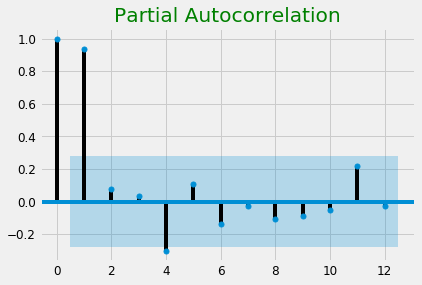

In [95]:
plot_pacf(df_h2['MA'], lags = 12); 

# rule if pacf has a sharp cut off then consider using A. the lag is AR parameter
# here lag of 1

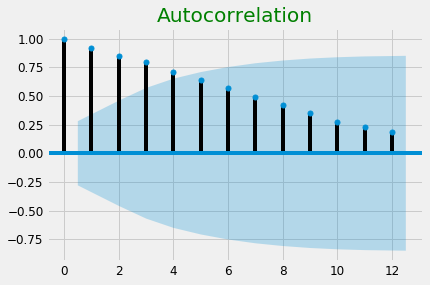

In [96]:
plot_acf(df_h2['MA'], lags = 12); 

# if the acf decreases more slowly (has significant values at higher lags) and pacf has a sharp drop it implies MA should not be used

In [97]:
# suggested by plots and differencing
# AR = 1
# I = 1
# MA = 0 or 1

stepwise_fit = auto_arima(df_h2['MA'], start_p = 1, start_q= 0, max_p = 1, max_q = 1,seasonal = False, trace = True).summary()

Fit ARIMA: order=(1, 1, 0); AIC=961.434, BIC=967.048, Fit time=0.051 seconds
Fit ARIMA: order=(0, 1, 0); AIC=959.442, BIC=963.185, Fit time=0.000 seconds
Fit ARIMA: order=(0, 1, 1); AIC=961.433, BIC=967.046, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.082 seconds


In [99]:
stepwise_fit

# the best result is ARIMA (0,1,0) although not suggested by the acf and pacf plots

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   48
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -477.721
Method:                           css   S.D. of innovations           5082.632
Date:                Fri, 22 May 2020   AIC                            959.442
Time:                        23:04:44   BIC                            963.185
Sample:                             1   HQIC                           960.856
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1434.5417    733.615      1.955      0.056      -3.317    2872.400
==============================================================================
"""

## Model

In [ ]:
# house 2 bed

In [103]:
print(len(df_h2))
df_h2.tail()

49


,MA,type,bedrooms,Diff
saledate,,,,
2018-09-30,504318,house,2,-1798.0
2018-12-31,506001,house,2,1683.0
2019-03-31,496133,house,2,-9868.0
2019-06-30,500158,house,2,4025.0
2019-09-30,510712,house,2,10554.0


In [105]:
train = df_h2[:45]
test = df_h2[45:]

In [110]:
model = ARIMA(df_h2['MA'].astype('float64'), order = (0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.MA   No. Observations:                   48
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -477.721
Method:                           css   S.D. of innovations           5082.632
Date:                Fri, 22 May 2020   AIC                            959.442
Time:                        23:18:07   BIC                            963.185
Sample:                    12-31-2007   HQIC                           960.856
                         - 09-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1434.5417    733.615      1.955      0.056      -3.317    2872.400
==============================================================================
"""

In [112]:
start = len(train)
end = len(train) + len(test) -1

predictions = results.predict(start = start, end = end, typ = 'levels').rename('Predictions_ARIMA')

In [113]:
predictions

2018-12-31    505752.541667
2019-03-31    507435.541667
2019-06-30    497567.541667
2019-09-30    501592.541667
Freq: Q-DEC, Name: Predictions_ARIMA, dtype: float64

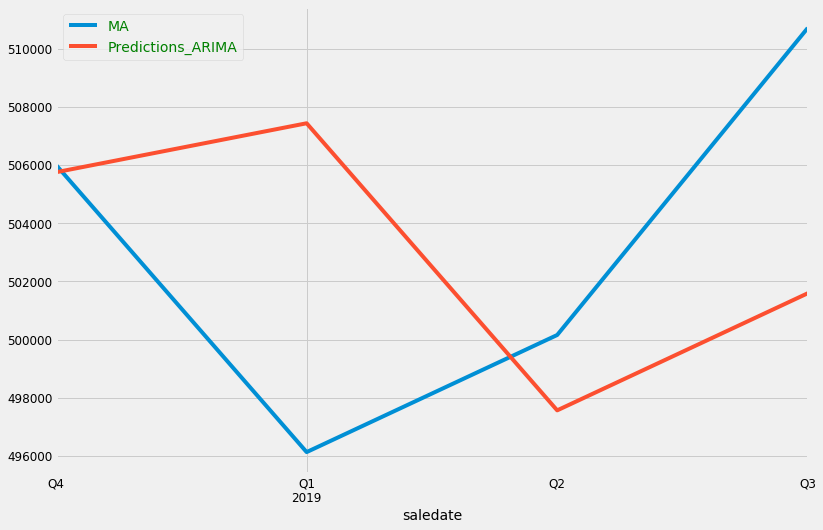

In [115]:
test['MA'].plot(figsize = (12,8), legend = True)
predictions.plot(legend=True)

In [123]:
# check the error 

from statsmodels.tools.eval_measures import rmse

error = rmse(test['MA'], predictions)
print(f"Error value: {error}")
print(f"Mean predictions value {predictions.mean()}")

Error value: 7377.0619886964105
Mean predictions value 503087.0416666667


In [122]:
# what is the scale of the error
mean_test = test.MA.mean()

print(f"The avg value of the test set: {mean_test}")

The avg value of the test set: 503251.0


## Forecast

### Forcasting with Arima

In [126]:
model = ARIMA(df_h2['MA'].astype('float64'), order = (0,1,0))
results = model.fit()
fcast = results.predict(start = len(df_h2['MA']), end = len(df_h2['MA'])+4, typ = 'levels').rename('Forecast Arima')

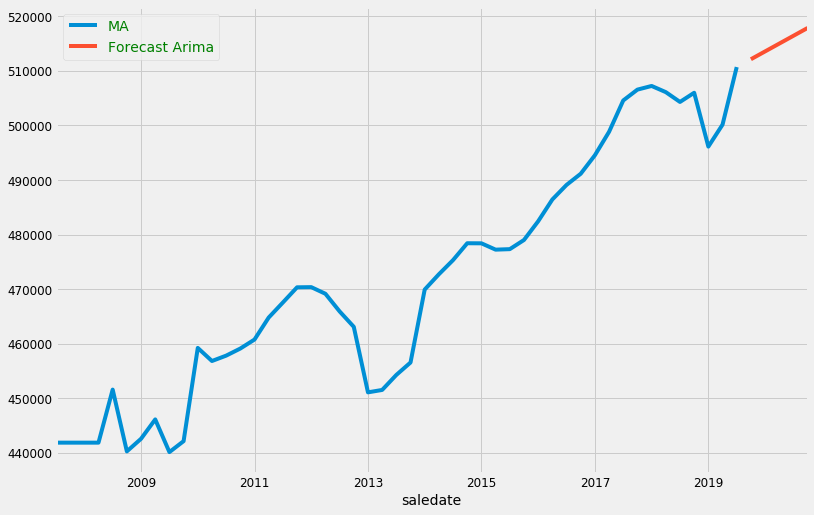

In [128]:
df_h2['MA'].plot(figsize = (12,8), legend = True)
fcast.plot(legend = True)

### Forcasting with Sarimax: Seasonal Variety of ARIMA

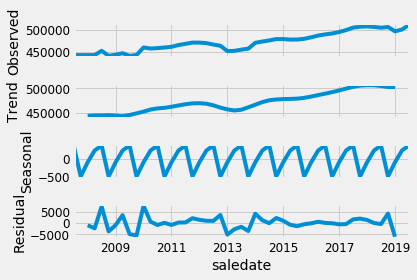

In [140]:
result = seasonal_decompose(df_h2['MA'])
result.plot();

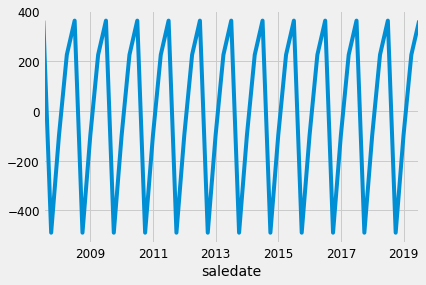

In [143]:
result.seasonal.plot()

In [129]:
# seasonal option

stepwise_fit = auto_arima(df_h2['MA'], start_p = 1, start_q= 0, max_p = 1, max_q = 1,seasonal = True, trace = True, m = 4).summary()

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 4); AIC=962.089, BIC=971.445, Fit time=0.115 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=959.442, BIC=963.185, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=961.242, BIC=968.727, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=961.214, BIC=968.699, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=959.224, BIC=964.838, Fit time=0.020 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 4); AIC=960.069, BIC=967.554, Fit time=0.085 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 4); AIC=960.980, BIC=970.336, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 4); AIC=961.315, BIC=968.800, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 4); AIC=963.161, BIC=972.517, Fit time=0.115 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 4);

In [130]:
stepwise_fit

# the best result is ARIMA (0,1,0) x (2,0,0,4) although not suggested by the acf and pacf plots

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   49
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 4)   Log Likelihood                -475.492
Date:                           Sat, 23 May 2020   AIC                            958.984
Time:                                   21:52:02   BIC                            966.469
Sample:                                        0   HQIC                           961.813
                                            - 49                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1434.5417    947.605      1.514      0.130    -422.730    3291.813
ar.S.L4        0.0185      0.088      0.210      0.834      -0.154       0.191
ar.S.L8       -0.0178      0.357     -0.050      0.960      -0.718       0.682
sigma2      2.583e+07      0.045   5.71e+08      0.000    2.58e+07    2.58e+07
===================================================================================
Ljung-Box (Q):                       35.14   Jarque-Bera (JB):                21.49
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.06
Prob(H) (two-sided):                  0.37   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+24. Standard errors may be unstable.
"""

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model = SARIMAX(df_h2['MA'].astype('float64'), order = (0,1,0), seasonal_order = (2, 0, 0, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                MA   No. Observations:                   49
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 4)   Log Likelihood                -477.301
Date:                           Sat, 23 May 2020   AIC                            960.603
Time:                                   22:13:27   BIC                            966.216
Sample:                               09-30-2007   HQIC                           962.724
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.0222      0.105      0.212      0.832      -0.183       0.228
ar.S.L8       -0.0140      0.175     -0.080      0.936      -0.357       0.329
sigma2      2.595e+07   7.59e-10   3.42e+16      0.000    2.59e+07    2.59e+07
===================================================================================
Ljung-Box (Q):                       37.02   Jarque-Bera (JB):                21.09
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.11
Prob(H) (two-sided):                  0.52   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
predictions_s = results.predict(start = start, end = end, typ = 'levels').rename('Predictions_SARIMAX')
predictions_s

2018-12-31    504333.497903
2019-03-31    505968.501094
2019-06-30    496047.773522
2019-09-30    500037.814575
Freq: Q-DEC, Name: Predictions_SARIMAX, dtype: float64

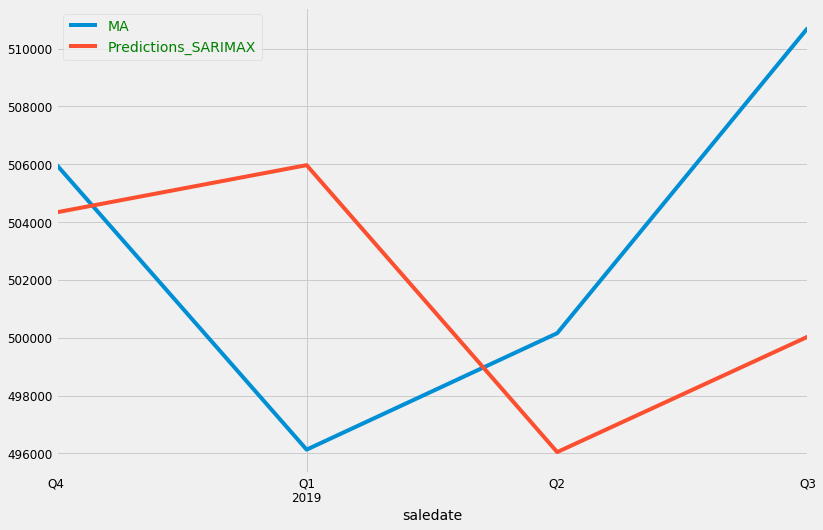

In [152]:
test['MA'].plot(figsize = (12,8), legend = True)
predictions_s.plot(legend=True)

In [155]:
# check the error 
#  non-seasonal model error is smaller 7377.0619886964105 

error = rmse(test['MA'], predictions_s)
print(f"Error value: {error}")
print(f"Mean predictions value {predictions_s.mean()}")

Error value: 7588.640214175788
Mean predictions value 501596.89677368


In [157]:
model = SARIMAX(df_h2['MA'].astype('float64'), order = (0,1,0), seasonal_order= (2, 0, 0, 4))
results = model.fit()
fcast = results.predict(start = len(df_h2['MA']), end = len(df_h2['MA'])+4, typ = 'levels').rename('Forecast Sarimax')

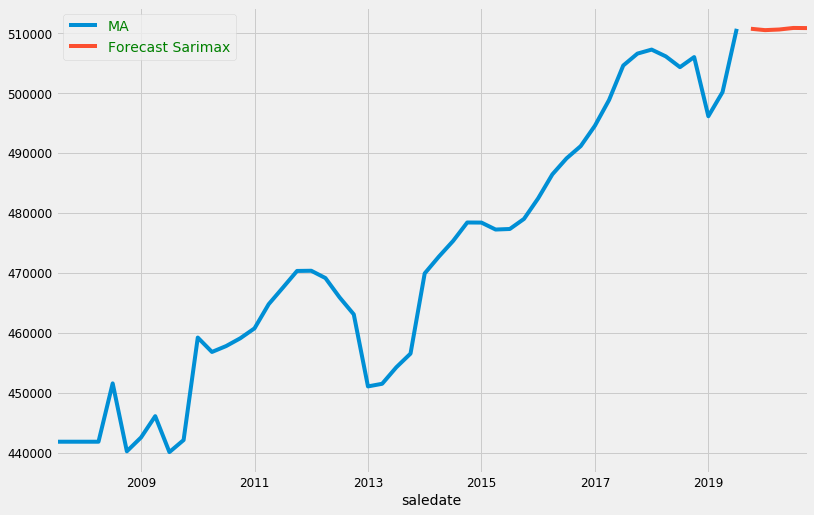

In [158]:
df_h2['MA'].plot(figsize = (12,8), legend = True)
fcast.plot(legend = True)